## This notebook does slew simulations, and check all aos components (M1M3, M2, hexapods) behavior during the slew-and-track process

This is expected to work both for SUMMIT and NCSA

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import rubin_jupyter_utils.lab.notebook as nb
nb.utils.get_node()

Patching auth into notebook.base.handlers.IPythonHandler(notebook.base.handlers.AuthenticatedHandler) -> IPythonHandler(jupyterhub.singleuser.mixins.HubAuthenticatedHandler, notebook.base.handlers.AuthenticatedHandler)


'andes03.cp.lsst.org'

In [3]:
from lsst.ts import salobj
import asyncio
import os
import yaml

import numpy as np
from matplotlib import pyplot as plt
from astropy.time import Time
from datetime import datetime, timedelta
import pandas as pd
import logging

from lsst.ts.idl.enums import MTHexapod

from lsst.ts.observatory.control.maintel.mtcs import MTCS, MTCSUsages
from lsst.ts.observatory.control import RotType
from astropy.coordinates import AltAz, ICRS, EarthLocation, Angle, FK5
import astropy.units as u

from aosTools import *

plt.jet();

Update leap second table
current_tai uses the system TAI clock
Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
NumExpr defaulting to 8 threads.


<Figure size 432x288 with 0 Axes>

In [4]:
summit = 1 #use this for summit testing
#summit = 0 #use this for NCSA

In [5]:
print(os.environ["OSPL_URI"])
print(os.environ["LSST_DDS_PARTITION_PREFIX"])
print(os.environ["LSST_DDS_DOMAIN_ID"])

file:///home/bxin/WORK/ts_ddsconfig/config/ospl-shmem.xml
summit
0


In [6]:
logging.basicConfig(format="%(name)s:%(message)s", level=logging.DEBUG)

In [7]:
from lsst_efd_client import EfdClient

if summit:
    client = EfdClient('summit_efd')
else:
    client = EfdClient('ncsa_teststand_efd')
csc_index = 1

In [8]:
#index is an integter which helps avoid multple users starting same controller
script = salobj.Controller("Script", index=7)

Read historical data in 0.00 sec


In [9]:
mtcs = MTCS(script.domain)
mtcs.set_rem_loglevel(40)

Read historical data in 0.09 sec
Read historical data in 0.16 sec
elevation DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is full (100 elements); data may be lost
cameraCableWrap DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 76 of 100 elements
timeAndDate DDS read queue is full (100 elements); data may be lost
rotation DDS read queue is full (100 elements); data may be lost
application DDS read queue is full (100 elements); data may be lost
azimuth DDS read queue is full (100 elements); data may be lost
application DDS read queue is filling: 78 of 100 elements
motors DDS read queue is full (100 elements); data may be lost
mountStatus DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is filling: 78 of 100 elements
electrical DDS read queue is full (100 elements); data may be lost
mountPosition DDS read queue 

In [10]:
await mtcs.start_task

[None, None, None, None, None, None, None, None, None, None]

In [11]:
mtcs.components_attr

['mtmount',
 'mtptg',
 'mtaos',
 'mtm1m3',
 'mtm2',
 'mthexapod_1',
 'mthexapod_2',
 'mtrotator',
 'mtdome',
 'mtdometrajectory']

In [12]:
ptg = mtcs.rem.mtptg
mount = mtcs.rem.mtmount
rot = mtcs.rem.mtrotator
camhex = mtcs.rem.mthexapod_1
m2hex = mtcs.rem.mthexapod_2
m1m3 = mtcs.rem.mtm1m3
m2 = mtcs.rem.mtm2
#aos = mtcs.rem.mtaos

### Get Ptg ready

In [13]:
await ptg.evt_heartbeat.next(flush=True, timeout=5)

In [20]:
await ptg.cmd_start.set_start()

In [101]:
await salobj.set_summary_state(ptg, salobj.State.ENABLED)

[<State.FAULT: 3>, <State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

### Get Mount ready

In [15]:
await mount.evt_heartbeat.next(flush=True, timeout=5)

In [16]:
sim_evt = await mount.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  1 2021-07-08 21:58:51.159002112


In [17]:
a = await mount.evt_softwareVersions.aget(timeout=5)
print('simulation mode? ', a.cscVersion, pd.to_datetime(a.private_sndStamp, unit='s'))

simulation mode?  0.18.1 2021-07-08 21:58:51.174109440


In [ ]:
a = await mount.evt_cameraCableWrapFollowing.aget()
print(a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))

In [41]:
await salobj.set_summary_state(mount, salobj.State.OFFLINE)

[<State.STANDBY: 5>, <State.OFFLINE: 4>]

In [25]:
await mount.cmd_start.set_start()

In [95]:
await salobj.set_summary_state(mount, salobj.State.ENABLED)

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [106]:
await showSlewError(ptg, mount, rot)

Camera cable wrap not following closely enough: error # 52 = -5.304842182718602 > 2.2 deg 2021-07-06 17:33:07.067059200
CCW folowing?  0 2021-07-06 17:50:10.558529536


### Get Rotator ready

In [59]:
await checkSlewCompStates(ptg, mount, rot)

staring with: ptg state State.ENABLED 2021-07-13 13:09:57.814151168
staring with: mount state State.ENABLED 2021-07-13 16:50:30.308591104
staring with: rot state State.STANDBY 2021-07-13 18:12:01.383107072


In [62]:
await salobj.set_summary_state(rot, salobj.State.OFFLINE)

[<State.ENABLED: 2>,
 <State.DISABLED: 1>,
 <State.STANDBY: 5>,
 <State.OFFLINE: 4>]

In [60]:
await salobj.set_summary_state(rot, salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [61]:
a = await mount.tel_elevation.next(flush=True, timeout=5)
print("mount elevation Angle = ", a.actualPosition)
a = await mount.tel_azimuth.next(flush=True, timeout=5)
print("mount azimuth angle = ", a.actualPosition)
a = await mount.tel_cameraCableWrap.next(flush=True, timeout=5)
print("CCW angle = ", a.actualPosition, " Needs to be within 2.2 deg of rotator angle ")
b = await rot.tel_rotation.next(flush=True, timeout=5)
print("rot angle = ", b.actualPosition, "   diff = ", (b.actualPosition - a.actualPosition))

mount elevation Angle =  90.0
mount azimuth angle =  0.0
CCW angle =  9.091558690357138  Needs to be within 2.2 deg of rotator angle 
rot angle =  9.091220857172544    diff =  -0.0003378331845933502


In [78]:
a = await rot.evt_errorCode.aget()
print(a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

Camera cable wrap telemetry is too old: dt=1.0466656684875488; abs(dt) > 1 2021-07-13 19:47:07.063443200


In [22]:
#if you get the "CCW telemetry too old", check the below. The CSC checks timestamp, not private_sndStamp
a=await mount.tel_cameraCableWrap.next(flush=True, timeout=5)
print(pd.to_datetime(a.private_sndStamp, unit='s'), a.actualPosition)
print(pd.to_datetime(a.timestamp, unit='s'), a.actualPosition)
a=await rot.tel_rotation.next(flush=True, timeout=5)
print(pd.to_datetime(a.private_sndStamp, unit='s'), a.actualPosition)
print(pd.to_datetime(a.timestamp, unit='s'), a.actualPosition)

2021-07-13 16:00:51.067101696 9.091310131847155
2021-07-13 16:00:51.064381952 9.091310131847155
2021-07-13 16:00:51.112577536 9.091326966411486
2021-07-13 16:00:51.112210176 9.091326966411486


In [23]:
sim_evt = await rot.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  0 2021-06-30 20:44:27.553741568


In [63]:
#a = await mount.evt_cameraCableWrapState.aget(timeout=5.)
#print(a.state)
a = await mount.evt_cameraCableWrapFollowing.aget(timeout=5.)
print(a.enabled)

0


In [64]:
await mount.cmd_enableCameraCableWrapFollowing.set_start()

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=690344821, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result="Failed: RuntimeError('<DeviceId.CAMERA_CABLE_WRAP: 4> off')")

In [57]:
await rot.cmd_clearError.set_start()

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=127523492, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: Failed: final state is <State.FAULT: 3> instead of <State.STANDBY: 5>')

In [29]:
await rot.cmd_start.set_start()

In [65]:
await salobj.set_summary_state(mount, salobj.State.DISABLED)
await salobj.set_summary_state(mount, salobj.State.ENABLED)
a = await mount.evt_cameraCableWrapFollowing.aget()
print('CCW folowing? ', a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))

CCW folowing?  1 2021-07-13 18:17:59.953999872


In [185]:
await rot.cmd_move.set_start(0)

AckTimeoutError: msg='Timed out waiting for command acknowledgement', ackcmd=(ackcmd private_seqNum=1147273772, ack=<SalRetCode.CMD_NOACK: -301>, error=0, result='No command acknowledgement seen')

### test the slew simulations without AOS components

In [21]:
#comment and uncomment the below depending on which components are expected to be on
#by default, MTCS checks on every component (during the slew).
mtcs.check.mtaos = False
mtcs.check.mtm1m3 = False
mtcs.check.mtm2 = False
mtcs.check.mthexapod_1 = False
mtcs.check.mthexapod_2 = False
mtcs.check.mtdome = False
mtcs.check.mtdometrajectory = False

In [22]:
dec = -34.
for j in range(2):
    time_and_date = await mtcs.rem.mtptg.tel_timeAndDate.next(flush=True, timeout=5)
    ra = time_and_date.lst + 0.5
    for i in range(2):
        print(ra, dec)
        await mtcs.slew_icrs(ra=ra, dec=dec, rot=0., rot_type=RotType.PhysicalSky)
        await asyncio.sleep(39.)
        ra -= 3.5/15.0

await mtcs.stop_tracking()

7.040823611268903 -34.0


Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


6.807490277935569 -34.0


Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


7.074120978262743 -34.0


Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


6.84078764492941 -34.0


Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


In [24]:
a =await mount.evt_target.aget(timeout=5.)
print(a.elevation)

85.05965471331558


In [46]:
await mtcs.stop_tracking()

MTCS:Stop tracking.


In [42]:
await mtcs.slew_icrs(ra=ra, dec=dec, rot=0.0, rot_type=RotType.Physical)

(<ICRS Coordinate: (ra, dec) in deg
     (59.5686106, -34.)>,
 <Angle 0. deg>)

In [22]:
dec = -34.
for j in range(2):
    for i in range(2):
        
        time_and_date = await mtcs.rem.mtptg.tel_timeAndDate.next(flush=True, timeout=5)
        ra = time_and_date.lst + 0.5 - 3.5/15.0 * i
        
        aa = await mount.tel_elevation.next(flush=True, timeout=5.)
        current_el = aa.actualPosition
        
        obs_time = salobj.astropy_time_from_tai_unix(salobj.current_tai() + 0.) #with 0s delay
        azel = mtcs.azel_from_radec(ra=ra, dec=dec, time=obs_time)
        target_el = azel.alt.value
        
        while abs(target_el - current_el)>0.3:
            print('moving from elevation %.1f deg to %.1f deg'%(current_el, target_el), Time.now())
            await moveMountConstantV(mount, current_el, target_el)
        
            aa = await mount.tel_elevation.next(flush=True, timeout=5.)
            current_el = aa.actualPosition
        
            time_and_date = await mtcs.rem.mtptg.tel_timeAndDate.next(flush=True, timeout=5)
            ra = time_and_date.lst + 0.5 - 3.5/15.0 * i
    
            obs_time = salobj.astropy_time_from_tai_unix(salobj.current_tai() + 0.) #with 0s delay
            azel = mtcs.azel_from_radec(ra=ra, dec=dec, time=obs_time)
            target_el = azel.alt.value
        
        print('start a slew, elevation diff = ', abs(target_el - current_el), Time.now())

        #b = await mount.tel_cameraCableWrap.next(flush=True, timeout=5) #CCW doesn't follow rotator!!!
        #await mtcs.slew_icrs(ra=ra, dec=dec, rot=b.actualPosition, rot_type=RotType.PhysicalSky)
        await mtcs.slew_icrs(ra=ra, dec=dec, rot=0.0, rot_type=RotType.Physical)
        await asyncio.sleep(39.)
        await mtcs.stop_tracking()

moving from elevation 89.9 deg to 82.5 deg 2021-06-07 15:18:31.547522
This will run for 355 seconds
89.86938467561717 0.0 0.016666666666666666 0.016666666666666666
89.83605134228384 0.0 0.03333333333333333 0.03333333333333333
89.8027180089505 0.0 0.05 0.05
89.76938467561716 0.0 0.06666666666666667 0.06666666666666667
89.73605134228383 0.0 0.08333333333333333 0.08333333333333333
89.7027180089505 0.0 0.09999999999999999 0.09999999999999999
89.66938467561717 0.0 0.11666666666666665 0.11666666666666665
89.63605134228384 0.0 0.13333333333333333 0.13333333333333333
89.6027180089505 0.0 0.15 0.15
89.56938467561717 0.0 0.16666666666666666 0.16666666666666666
89.53605134228384 0.0 0.18333333333333332 0.18333333333333332
89.5027180089505 0.0 0.19999999999999998 0.19999999999999998
89.46938467561716 0.0 0.21666666666666665 0.21666666666666665
89.43605134228383 0.0 0.2333333333333333 0.2333333333333333
89.4027180089505 0.0 0.24999999999999997 0.24999999999999997
89.36938467561717 0.0 0.26666666666

Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


moving from elevation 82.7 deg to 84.9 deg 2021-06-07 15:27:18.101754
This will run for 104 seconds
82.74483240724156 0.0 0.016666666666666666 0.016666666666666666
82.77816574057489 0.0 0.03333333333333333 0.03333333333333333
82.81149907390822 0.0 0.05 0.05
82.84483240724157 0.0 0.06666666666666667 0.06666666666666667
82.8781657405749 0.0 0.08333333333333333 0.08333333333333333
82.91149907390823 0.0 0.09999999999999999 0.09999999999999999
82.94483240724156 0.0 0.11666666666666665 0.11666666666666665
82.9781657405749 0.0 0.13333333333333333 0.13333333333333333
83.01149907390823 0.0 0.15 0.15
83.04483240724156 0.0 0.16666666666666666 0.16666666666666666
83.07816574057489 0.0 0.18333333333333332 0.18333333333333332
83.11149907390823 0.0 0.19999999999999998 0.19999999999999998
83.14483240724157 0.0 0.21666666666666665 0.21666666666666665
83.1781657405749 0.0 0.2333333333333333 0.2333333333333333
83.21149907390823 0.0 0.24999999999999997 0.24999999999999997
83.24483240724156 0.0 0.266666666

Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


moving from elevation 85.0 deg to 82.5 deg 2021-06-07 15:30:55.975354
This will run for 121 seconds
85.00424732897483 0.0 0.016666666666666666 0.016666666666666666
84.9709139956415 0.0 0.03333333333333333 0.03333333333333333
84.93758066230816 0.0 0.05 0.05
84.90424732897482 0.0 0.06666666666666667 0.06666666666666667
84.87091399564149 0.0 0.08333333333333333 0.08333333333333333
84.83758066230816 0.0 0.09999999999999999 0.09999999999999999
84.80424732897482 0.0 0.11666666666666665 0.11666666666666665
84.7709139956415 0.0 0.13333333333333333 0.13333333333333333
84.73758066230816 0.0 0.15 0.15
84.70424732897483 0.0 0.16666666666666666 0.16666666666666666
84.6709139956415 0.0 0.18333333333333332 0.18333333333333332
84.63758066230815 0.0 0.19999999999999998 0.19999999999999998
84.60424732897482 0.0 0.21666666666666665 0.21666666666666665
84.57091399564149 0.0 0.2333333333333333 0.2333333333333333
84.53758066230816 0.0 0.24999999999999997 0.24999999999999997
84.50424732897483 0.0 0.266666666

Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


moving from elevation 82.7 deg to 84.9 deg 2021-06-07 15:34:49.339407
This will run for 104 seconds
82.74434681444616 0.0 0.016666666666666666 0.016666666666666666
82.77768014777949 0.0 0.03333333333333333 0.03333333333333333
82.81101348111282 0.0 0.05 0.05
82.84434681444617 0.0 0.06666666666666667 0.06666666666666667
82.8776801477795 0.0 0.08333333333333333 0.08333333333333333
82.91101348111283 0.0 0.09999999999999999 0.09999999999999999
82.94434681444616 0.0 0.11666666666666665 0.11666666666666665
82.9776801477795 0.0 0.13333333333333333 0.13333333333333333
83.01101348111283 0.0 0.15 0.15
83.04434681444616 0.0 0.16666666666666666 0.16666666666666666
83.07768014777949 0.0 0.18333333333333332 0.18333333333333332
83.11101348111283 0.0 0.19999999999999998 0.19999999999999998
83.14434681444617 0.0 0.21666666666666665 0.21666666666666665
83.1776801477795 0.0 0.2333333333333333 0.2333333333333333
83.21101348111283 0.0 0.24999999999999997 0.24999999999999997
83.24434681444616 0.0 0.266666666

Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


### Check that all components are ready

In [24]:
await checkAOSCompStates(m1m3, m2, camhex, m2hex)

starting with: M1M3 state State.STANDBY 2021-07-13 15:31:47.368913152
          detailed state DetailedState.STANDBY 2021-07-13 15:31:47.369053440


TimeoutError: 

In [99]:
await checkSlewCompStates(ptg, mount, rot)

staring with: ptg state State.FAULT 2021-07-06 17:49:01.893497344
staring with: mount state State.ENABLED 2021-07-06 17:44:00.675299072
staring with: rot state State.STANDBY 2021-07-06 17:43:18.963350016


### Get M1M3 ready (Mount telemetry mode)

In [70]:
#Move to zenith (so that we can start m1m3 with LUT in mount telemetry mode)
await mount.cmd_moveToTarget.set_start(azimuth=0, elevation=90)

In [26]:
await m1m3.evt_heartbeat.next(flush=True, timeout=5)

In [72]:
await salobj.set_summary_state(m1m3, salobj.State.STANDBY)

[<State.FAULT: 3>, <State.STANDBY: 5>]

In [55]:
print('Re-enabling M1M3')
#await salobj.set_summary_state(m1m3, salobj.State.STANDBY) 
await salobj.set_summary_state(m1m3, salobj.State.ENABLED, settingsToApply = 'Default') #enable m1m3

Re-enabling M1M3


forceActuatorForceWarning DDS read queue is full (100 elements); data may be lost


[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [56]:
await readyM1M3(m1m3)

m1m3 inclinometer Angle =  90.00399780273438
m1m3 state DetailedState.RAISING 2021-07-13 16:59:28.446536192
m1m3 state DetailedState.ACTIVE 2021-07-13 17:04:42.364613120
m1m3 z position =  0.0
Magnitude of the m1m3 force balance system 177.1709747314453


In [73]:
await m1m3.cmd_abortRaiseM1M3.set_start(timeout=15.)

In [50]:
a = await m1m3.evt_errorCode.aget()
print(a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

TMA Azimuth timeouted (-0.502s) 2021-07-13 16:50:06.858978048


In [71]:
await lowerM1M3(m1m3)

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=1093916491, ack=<SalRetCode.CMD_FAILED: -302>, error=0, result='Failed: The command LowerM1M3 is not valid in the FaultState.')

### Get M2 ready

In [29]:
await m2.evt_heartbeat.next(flush=True, timeout=5)

In [33]:
await checkAOSCompStates(m1m3,m2,camhex,m2hex)

starting with: M1M3 state State.ENABLED 2021-07-13 16:08:32.152454912
          detailed state DetailedState.ACTIVE 2021-07-13 16:08:32.152486400
staring with: m2 state State.ENABLED 2021-07-13 16:29:22.351926016
staring with: cam hex state State.ENABLED 2021-07-13 15:31:53.177814528
          cam hex state EnabledSubstate.STATIONARY 2021-07-13 15:32:08.343293440
staring with: M2 hex state State.STANDBY 2021-07-06 21:32:55.996532224
          hex state EnabledSubstate.STATIONARY 2021-07-06 21:32:55.996777216


In [124]:
await salobj.set_summary_state(m2, salobj.State.OFFLINE) 

[<State.DISABLED: 1>, <State.STANDBY: 5>, <State.OFFLINE: 4>]

In [69]:
await salobj.set_summary_state(m2, salobj.State.STANDBY) 

[<State.OFFLINE: 4>, <State.STANDBY: 5>]

In [70]:
await salobj.set_summary_state(m2, salobj.State.DISABLED) 

[<State.STANDBY: 5>, <State.DISABLED: 1>]

In [32]:
#remember to reset interlock
await salobj.set_summary_state(m2, salobj.State.ENABLED) 

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [68]:
a = await m2.evt_errorCode.aget()
print(a.errorCode, a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

6052  2021-07-06 17:16:49.473226752


In [33]:
await m2.cmd_enterControl.set_start(timeout=.5)

In [34]:
await m2.cmd_exitControl.set_start(timeout=.5)

In [36]:
await m2.cmd_enable.set_start(timeout=5.)

AckTimeoutError: msg='Timed out waiting for command acknowledgement', ackcmd=(ackcmd private_seqNum=568344813, ack=<SalRetCode.CMD_ACK: 300>, error=0, result='SAL ACK')

In [20]:
await m2.cmd_disable.set_start(timeout=5.)

In [67]:
await m2.cmd_clearErrors.set_start(timeout=15.)

AckTimeoutError: msg='Timed out waiting for command acknowledgement', ackcmd=(ackcmd private_seqNum=277343345, ack=<SalRetCode.CMD_ACK: 300>, error=0, result='Ack : OK')

In [34]:
await readyM2(m2)

m2 inclinometer angle =  0.40800231933593434
Inclinometer Source InclinationTelemetrySource.MTMOUNT  ,event time =  2021-07-13 16:25:59.604194048
Status of the M2 force balance system True
clear any M2 activeopticForces (or any other hunman-applied forces)


### Get camHex ready

In [35]:
target_evt = await mount.evt_target.aget(timeout=5.)
print("Mount target elevation = ", target_evt.elevation, "  @  ", pd.to_datetime(target_evt.private_sndStamp, unit='s'))
print("Mount target azimuth   = ", target_evt.azimuth, "  @  ", pd.to_datetime(target_evt.private_sndStamp, unit='s'))
target_evt = await rot.evt_target.aget(timeout=5.)
print("Rotator target position = ", target_evt.position, "  @  ", pd.to_datetime(target_evt.private_sndStamp, unit='s'))

Mount target elevation =  90.0   @   2021-07-13 16:03:25.066260480
Mount target azimuth   =  0.0   @   2021-07-13 16:03:25.066260480
Rotator target position =  10.009884332662548   @   2021-07-06 21:03:56.538422784


In [ ]:
#if any of the above doesn't work
await mount.cmd_moveToTarget.set_start(azimuth=0, elevation=90)
await rot.cmd_move.set_start(position=0)

In [33]:
a=await mount.tel_cameraCableWrap.next(flush=True, timeout=5)
print(pd.to_datetime(a.private_sndStamp, unit='s'), a.actualPosition)
print(pd.to_datetime(a.timestamp, unit='s'), a.actualPosition)
a=await camhex.tel_application.next(flush=True, timeout=5)
print(pd.to_datetime(a.private_sndStamp, unit='s'), a.position[0])
#print(pd.to_datetime(a.timestamp, unit='s'), a.position[0])

2021-07-02 16:52:19.725534720 -1.3146883442912014
2021-07-02 16:52:19.724618496 -1.3146883442912014
2021-07-02 16:52:19.801730048 0.04023863026391933


In [36]:
await camhex.evt_heartbeat.next(flush=True, timeout=5)

In [37]:
sim_evt = await camhex.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  0 2021-06-30 20:47:01.529544448


In [82]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [129]:
await camhex.cmd_clearError.set_start()

In [84]:
await salobj.set_summary_state(camhex, salobj.State.ENABLED, settingsToApply='default')

[<State.ENABLED: 2>]

In [38]:
await readyHexaForAOS(camhex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-07-13 13:37:21.582045696
pivot at (0, 0, -2758400) microns 
maxXY =  11400.0 microns, maxZ=  13100.0  microns
maxUV =  0.36 deg, maxW=  0.1  deg
compsensation mode enabled? True 2021-07-13 16:31:33.257118208
hexa in position? False 2021-07-13 16:31:33.398373632
hexa in position? True 2021-07-13 16:31:36.330668032
Current Hexapod position
     -1.17    -653.03     395.93  -0.017750   0.000007   0.000000
hexa in position? False 2021-07-13 16:31:36.550862336
hexa in position? True 2021-07-13 16:31:38.082689280
Current Hexapod position
     -1.12    -653.36     295.26  -0.017759   0.000007  -0.000009
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-07-13 16:31:36.377239808
Compensated position
     -0.93    -652.98     295.56      -0.017752   0.000000   0.000000    2021-07-13 16:31:36.377444352
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do no

In [37]:
import lsst.ts.idl.enums.MTHexapod as enum_hex
a = await camhex.evt_controllerState.aget()
print(a.applicationStatus, pd.to_datetime(a.private_sndStamp, unit='s'))
enum_hex.ApplicationStatus(a.applicationStatus[0])

[1026, 0, 0, 0, 0, 0] 2021-07-02 16:52:44.256530432


<ApplicationStatus.DDS_COMMAND_SOURCE|MOVE_COMPLETE: 1026>

### Get m2Hex ready

In [41]:
await salobj.set_summary_state(m2hex, salobj.State.ENABLED, settingsToApply='default') #works if it is offline

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [39]:
sim_evt = await m2hex.evt_simulationMode.aget(timeout=5)
print('simulation mode? ', sim_evt.mode, pd.to_datetime(sim_evt.private_sndStamp, unit='s'))

simulation mode?  1 2021-07-01 16:44:55.176457472


In [42]:
await readyHexaForAOS(m2hex)

settingsVersion =  default.yaml:v0.7.4-0-g70e7a58 2021-07-01 16:48:37.845231872
pivot at (0, 0, 500000) microns 
maxXY =  10500.0 microns, maxZ=  8900.0  microns
maxUV =  0.175 deg, maxW=  0.05  deg
compsensation mode enabled? True 2021-07-13 16:33:15.983985408
hexa in position? True 2021-07-13 16:33:16.030857216
Current Hexapod position
     -1.87    -572.58     404.72  -0.006649  -0.000000  -0.000000
hexa in position? True 2021-07-13 16:33:16.535939072
Current Hexapod position
     -1.80    -572.60     304.67  -0.006649   0.000000  -0.000000
Uncompensated position
      0.00       0.00       0.00      0.000000   0.000000   0.000000    2021-07-13 16:33:16.737339136
Compensated position
     -1.84    -572.60     304.70      -0.006649   0.000000   0.000000    2021-07-13 16:33:16.737540096
Does the hexapod has enough inputs to do LUT compensation? (If the below times out, we do not.)
mount elevation =  90.0
mount azimth =  0.0
rotator angle =  10.009884332662551
? temperature =  0.0
x,y,

In [78]:
end = Time(datetime.now(), scale='tai')
start = end - timedelta(seconds=1000)
df = await client.select_time_series('lsst.sal.ESS.temperature8Ch', '*', start, end, csc_index)
if len(df)>0:
    fig, ax = plt.subplots(1,1, figsize=(15,4))
    for i in range(8):
        plt.plot(getattr(df, 'temperatureC%02d'%i))
    plt.grid()
else:
    print('No temperature data on the camera hexapod in the past 1000s.')

No temperature data on the camera hexapod in the past 1000s.


### Do a few slews

In [43]:
#comment and uncomment the below depending on which components are expected to be on
#by default, MTCS checks on every component (during the slew).
mtcs.check.mtaos = False
mtcs.check.mtm1m3 = True
mtcs.check.mtm2 = True
mtcs.check.mthexapod_1 = True
mtcs.check.mthexapod_2 = True
mtcs.check.mtdome = False
mtcs.check.mtdometrajectory = False

In [46]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
    
await salobj.set_summary_state(mount, salobj.State.DISABLED)
await asyncio.sleep(1.0)
await salobj.set_summary_state(mount, salobj.State.ENABLED)

mount.evt_logMessage.callback = printLogMessage
await mount.cmd_setLogLevel.set_start(level=10, timeout=5)

In [62]:
a = await mount.evt_cameraCableWrapFollowing.aget()
print(a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))

#a = await mount.tel_elevation.next(flush=True, timeout=5.)
#await mount.cmd_moveToTarget.set_start(azimuth=0, elevation=a.actualPosition-1)
#await asyncio.sleep(1.0)
#a = await mount.evt_cameraCableWrapFollowing.aget()
#print(a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))

0 2021-07-13 16:55:24.430684160


In [14]:
a = await mount.evt_logMessage.aget()
print(a.message)

Failed to send command CameraCableWrapStop(sequence_id=68553, command_code=<CommandCode.CAMERA_CABLE_WRAP_STOP: 1002>, source=<Source.CSC: 1>, timestamp=1625600545.4500663): ExpectedError("RuntimeError('<DeviceId.CAMERA_CABLE_WRAP: 4> off')")


#### Do 4 slews, then stop tracking

In [66]:
await rot.cmd_move.set_start(position=0, timeout=30.)

In [67]:
rot.evt_inPosition.flush()
await rot.cmd_move.set_start(position=10., timeout = 30)
while True:
    state = await rot.evt_inPosition.next(flush=False, timeout=30)
    print('rot in position?', state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
    if (state.inPosition):
        break

rot in position? False 2021-07-13 18:32:37.763851520
rot in position? True 2021-07-13 18:32:44.163464960


In [69]:
dec = -34.
for j in range(2):
    for i in range(2):
        
        a = await mount.evt_cameraCableWrapFollowing.aget()
        print('CCW folowing? ', a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))
        if not a.enabled:
            break
        time_and_date = await mtcs.rem.mtptg.tel_timeAndDate.next(flush=True, timeout=5)
        ra = time_and_date.lst + 0.5 - 3.5/15.0 * i
        
        aa = await mount.tel_elevation.next(flush=True, timeout=5.)
        current_el = aa.actualPosition
        
        obs_time = salobj.astropy_time_from_tai_unix(salobj.current_tai() + 0.) #with 0s delay
        azel = mtcs.azel_from_radec(ra=ra, dec=dec, time=obs_time)
        target_el = azel.alt.value
        
        while abs(target_el - current_el)>0.3:
            print('moving from elevation %.1f deg to %.1f deg'%(current_el, target_el), Time.now())
            await moveMountConstantV(mount, current_el, target_el)
        
            aa = await mount.tel_elevation.next(flush=True, timeout=5.)
            current_el = aa.actualPosition
        
            time_and_date = await mtcs.rem.mtptg.tel_timeAndDate.next(flush=True, timeout=5)
            ra = time_and_date.lst + 0.5 - 3.5/15.0 * i
    
            obs_time = salobj.astropy_time_from_tai_unix(salobj.current_tai() + 0.) #with 0s delay
            azel = mtcs.azel_from_radec(ra=ra, dec=dec, time=obs_time)
            target_el = azel.alt.value
        
        rot.evt_inPosition.flush()
        await rot.cmd_move.set_start(position=10., timeout = 30)
        while True:
            state = await rot.evt_inPosition.next(flush=False, timeout=30)
            print('rot in position?', state.inPosition, pd.to_datetime(state.private_sndStamp, unit='s'))
            if (state.inPosition):
                break
        
        print('start a slew, elevation diff = ', abs(target_el - current_el), Time.now())
        a = await mount.evt_cameraCableWrapFollowing.aget()
        print('CCW folowing? ', a.enabled, pd.to_datetime(a.private_sndStamp, unit='s'))
        if not a.enabled:
            break
        rotAngle = 10.0
        print('rot = ', rotAngle)
        #b = await mount.tel_cameraCableWrap.next(flush=True, timeout=5) #CCW doesn't follow rotator!!!
        # await mtcs.slew_icrs(ra=ra, dec=dec, rot=b.actualPosition, rot_type=RotType.PhysicalSky)
        await mtcs.slew_icrs(ra=ra, dec=dec, rot=rotAngle, rot_type=RotType.PhysicalSky)
        #await mtcs.slew_icrs(ra=ra, dec=dec, rot=0.0, rot_type=RotType.Physical)
        await asyncio.sleep(39.)
        await mtcs.stop_tracking()

CCW folowing?  1 2021-07-13 18:17:59.953999872
moving from elevation 84.9 deg to 82.4 deg 2021-07-13 18:58:51.704319
This will run for 121 seconds
rot in position? True 2021-07-13 19:02:18.513651200
start a slew, elevation diff =  0.08016567128784402 2021-07-13 19:01:41.522233
CCW folowing?  1 2021-07-13 18:17:59.953999872
rot =  10.0


Got False
Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


CCW folowing?  1 2021-07-13 18:17:59.953999872
moving from elevation 82.6 deg to 84.7 deg 2021-07-13 19:02:48.017838
This will run for 102 seconds
rot in position? True 2021-07-13 19:05:54.601592320
start a slew, elevation diff =  0.08938484923064038 2021-07-13 19:05:17.612815
CCW folowing?  1 2021-07-13 18:17:59.953999872
rot =  10.0


Got False
Waiting for telescope to settle.
Telescope in position.
Got True
Rotator in position.


CCW folowing?  1 2021-07-13 18:17:59.953999872
moving from elevation 85.0 deg to 82.4 deg 2021-07-13 19:07:24.851823
This will run for 126 seconds
rot in position? True 2021-07-13 19:10:57.134646272
start a slew, elevation diff =  0.10066321941829415 2021-07-13 19:10:20.137816
CCW folowing?  1 2021-07-13 18:17:59.953999872
rot =  10.0


Got False
Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


CCW folowing?  1 2021-07-13 18:17:59.953999872
moving from elevation 82.6 deg to 84.7 deg 2021-07-13 19:11:26.811802
This will run for 102 seconds
rot in position? True 2021-07-13 19:14:33.272543488
start a slew, elevation diff =  0.08589738563405547 2021-07-13 19:13:56.290386
CCW folowing?  1 2021-07-13 18:17:59.953999872
rot =  10.0


Got False
Got True
Rotator in position.
Waiting for telescope to settle.
Telescope in position.


In [43]:
await showSlewError(ptg, mount, rot)

Camera cable wrap not following closely enough: error # 52 = -5.304842182718602 > 2.2 deg 2021-07-06 17:33:07.067059200
CCW folowing?  1 2021-07-06 20:56:59.276886528


In [44]:
await checkSlewCompStates(ptg, mount, rot)

staring with: ptg state State.FAULT 2021-07-06 21:03:56.588785408
staring with: mount state State.ENABLED 2021-07-06 20:56:59.277519616
staring with: rot state State.FAULT 2021-07-06 21:03:56.547283456


In [45]:
a = await rot.evt_errorCode.aget()
print(a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))
a = await rot.evt_logMessage.aget()
print(a.message, pd.to_datetime(a.private_sndStamp, unit='s'))
import lsst.ts.idl.enums.MTRotator as enum_rot
a = await rot.evt_controllerState.aget()
print(a.applicationStatus, pd.to_datetime(a.private_sndStamp, unit='s'))
enum_rot.ApplicationStatus(a.applicationStatus)

Camera cable wrap not following closely enough: error # 52 = -5.304842182718602 > 2.2 deg 2021-07-06 17:33:07.067059200


RuntimeError: Not allowed because there is a callback function

In [128]:
a = await camhex.evt_errorCode.aget()
print(a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

CancelledError: 

In [132]:
import lsst.ts.idl.enums.MTHexapod as enum_hex
a = await camhex.evt_controllerState.aget()
print(a.applicationStatus, pd.to_datetime(a.private_sndStamp, unit='s'))
enum_hex.ApplicationStatus(a.applicationStatus[0])

[29700, 0, 0, 0, 0, 0] 2021-07-06 18:46:42.994284544


<ApplicationStatus.SIMULINK_FAULT|DRIVE_FAULT|DDS_CONNECTED|DDS_COMMAND_SOURCE|EUI_CONNECTED: 29700>

In [34]:
await rot.cmd_clearError.set_start()

In [39]:
await checkSlewCompStates(ptg, mount, rot)

staring with: ptg state State.ENABLED 2021-07-06 20:56:53.481703168
staring with: mount state State.ENABLED 2021-07-06 20:56:59.277519616
staring with: rot state State.ENABLED 2021-07-06 20:56:49.864164352


In [35]:
await salobj.set_summary_state(rot, state=salobj.State.ENABLED)

[<State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [36]:
await salobj.set_summary_state(ptg, state=salobj.State.ENABLED)

[<State.FAULT: 3>, <State.STANDBY: 5>, <State.DISABLED: 1>, <State.ENABLED: 2>]

In [37]:
await salobj.set_summary_state(mount, state=salobj.State.DISABLED)

[<State.ENABLED: 2>, <State.DISABLED: 1>]

In [38]:
await salobj.set_summary_state(mount, state=salobj.State.ENABLED)

[<State.DISABLED: 1>, <State.ENABLED: 2>]

In [163]:
await mount.cmd_enableCameraCableWrapFollowing.set_start()

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=690344821, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result="Failed: RuntimeError('<DeviceId.CAMERA_CABLE_WRAP: 4> off')")

In [16]:
await mtcs.enable_ccw_following()

Enabling CCW following.


AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=690344821, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result="Failed: RuntimeError('<DeviceId.CAMERA_CABLE_WRAP: 4> off')")

In [22]:
def printLogMessage(data):
    print(f"{data.level}: {data.message}")
rot.evt_logMessage.callback = printLogMessage
await rot.cmd_setLogLevel.set_start(level=10, timeout=5)

In [139]:
await camhex.cmd_clearError.set_start()

AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=172607481, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: Failed: final state is <State.FAULT: 3> instead of <State.STANDBY: 5>')

In [135]:
await checkAOSCompStates(m1m3,m2,camhex,m2hex)

starting with: M1M3 state State.ENABLED 2021-07-06 17:12:17.919976192
          detailed state DetailedState.ACTIVE 2021-07-06 17:12:17.920011008
staring with: m2 state State.ENABLED 2021-07-06 17:17:37.340900864
staring with: cam hex state State.FAULT 2021-07-06 18:46:42.993954304
          cam hex state EnabledSubstate.STATIONARY 2021-07-06 18:46:42.994284544
staring with: M2 hex state State.ENABLED 2021-07-06 15:48:02.461323520
          hex state EnabledSubstate.STATIONARY 2021-07-06 17:22:52.649073920


In [138]:
await salobj.set_summary_state(camhex, state=salobj.State.ENABLED)

RuntimeError: Error on cmd=cmd_standby, initial_state=3: msg='Command failed', ackcmd=(ackcmd private_seqNum=1874305940, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result='Failed: You must use the clearError command or the engineering user interface to clear a rotator fault.')

In [137]:
await mtcs.stop_tracking()

In [29]:
await mtcs.enable_ccw_following()

Enabling CCW following.


AckError: msg='Command failed', ackcmd=(ackcmd private_seqNum=690344822, ack=<SalRetCode.CMD_FAILED: -302>, error=1, result="Failed: RuntimeError('<DeviceId.CAMERA_CABLE_WRAP: 4> off')")

In [52]:
a =await mount.evt_logMessage.aget()
a.message, pd.to_datetime(a.private_sndStamp, unit='s')

('Failed to send command CameraCableWrapStop(sequence_id=452433, command_code=<CommandCode.CAMERA_CABLE_WRAP_STOP: 1002>, source=<Source.CSC: 1>, timestamp=1625245739.1863241): ExpectedError("RuntimeError(\'<DeviceId.CAMERA_CABLE_WRAP: 4> off\')")',
 Timestamp('2021-07-02 17:08:59.187008768'))

In [107]:
a = await rot.evt_errorCode.aget()
print(a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

Cannot read cameraCableWrap telemetry 2021-07-01 13:34:10.587981568


In [122]:
from lsst.ts.idl.enums.MTRotator import ApplicationStatus
a = await rot.evt_controllerState.aget()
print(a.applicationStatus, pd.to_datetime(a.private_sndStamp, unit='s'))

21508 2021-07-01 20:43:40.728502016


In [121]:
ApplicationStatus(a.applicationStatus)

<ApplicationStatus.SIMULINK_FAULT|DDS_CONNECTED|DDS_COMMAND_SOURCE|EUI_CONNECTED: 21508>

In [48]:
await rot.cmd_clearError.set_start()

In [54]:
a = await m1m3.evt_errorCode.aget()
print(a.errorReport, pd.to_datetime(a.private_sndStamp, unit='s'))

Hardpoint Actuator #2 Measured Forces 50


#### Plot the above process

In [27]:
end = Time(datetime.now(), scale='tai')
start = end - timedelta(seconds=1000)

In [30]:
dfm2

,applied0,applied1,applied10,applied11,applied12,applied13,applied14,applied15,applied16,applied17,...,measured8,measured9,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp
2021-05-26 23:31:28.527000+00:00,0,0,0,0,0,0,0,0,0,0,...,200.567169,174.139038,1,MTM2,1.622072e+09,14447,1.622072e+09,1272f82f,361524,1.622072e+09
2021-05-26 23:31:28.577000+00:00,0,0,0,0,0,0,0,0,0,0,...,200.607941,174.093338,1,MTM2,1.622072e+09,14447,1.622072e+09,1272f82f,361525,1.622072e+09
2021-05-26 23:31:28.627000+00:00,0,0,0,0,0,0,0,0,0,0,...,200.602844,174.184723,1,MTM2,1.622072e+09,14447,1.622072e+09,1272f82f,361526,1.622072e+09
2021-05-26 23:31:28.677000+00:00,0,0,0,0,0,0,0,0,0,0,...,200.613037,174.174576,1,MTM2,1.622072e+09,14447,1.622072e+09,1272f82f,361527,1.622072e+09
2021-05-26 23:31:28.727000+00:00,0,0,0,0,0,0,0,0,0,0,...,200.679321,174.184723,1,MTM2,1.622072e+09,14447,1.622072e+09,1272f82f,361528,1.622072e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-26 23:48:08.282000+00:00,0,0,0,0,0,0,0,0,0,0,...,195.311356,178.657639,1,MTM2,1.622073e+09,14447,1.622073e+09,1272f82f,381519,1.622073e+09
2021-05-26 23:48:08.331000+00:00,0,0,0,0,0,0,0,0,0,0,...,195.382721,178.738876,1,MTM2,1.622073e+09,14447,1.622073e+09,1272f82f,381520,1.622073e+09
2021-05-26 23:48:08.379000+00:00,0,0,0,0,0,0,0,0,0,0,...,195.290955,178.708420,1,MTM2,1.622073e+09,14447,1.622073e+09,1272f82f,381521,1.622073e+09
2021-05-26 23:48:08.431000+00:00,0,0,0,0,0,0,0,0,0,0,...,195.398010,178.769333,1,MTM2,1.622073e+09,14447,1.622073e+09,1272f82f,381522,1.622073e+09


powerSupplyData DDS read queue is full (100 elements); data may be lost
tangentEncoderPositions DDS read queue is full (100 elements); data may be lost
application DDS read queue is filling: 72 of 100 elements
actuators DDS read queue is filling: 70 of 100 elements
pidData DDS read queue is full (100 elements); data may be lost
tangentActuatorSteps DDS read queue is full (100 elements); data may be lost
actuators DDS read queue is filling: 78 of 100 elements
electrical DDS read queue is filling: 80 of 100 elements
inclinometerData DDS read queue is full (100 elements); data may be lost
electrical DDS read queue is filling: 76 of 100 elements
netMomentsTotal DDS read queue is full (100 elements); data may be lost
application DDS read queue is filling: 81 of 100 elements
imsData DDS read queue is full (100 elements); data may be lost
netForcesTotal DDS read queue is full (100 elements); data may be lost
hardpointMonitorData DDS read queue is full (100 elements); data may be lost
ilcData 

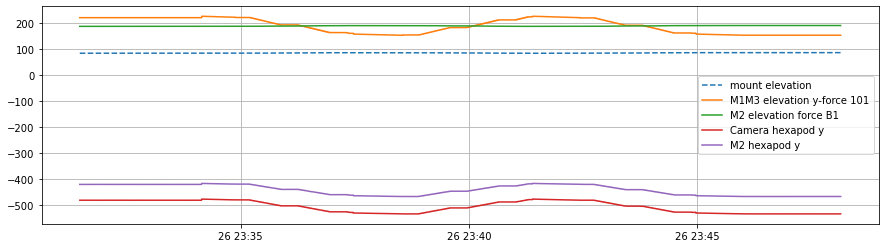

In [28]:
dfm = await client.select_time_series('lsst.sal.MTMount.elevation', '*', start, end, csc_index)
dfm1m3 = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedElevationForces', '*', start, end, csc_index)
dfm2 = await client.select_time_series('lsst.sal.MTM2.axialForce', '*', start, end, csc_index)
dfh = await client.select_time_series('lsst.sal.MTHexapod.application', '*', start, end, csc_index)

idx1=dfh.MTHexapodID==1
dfh1 = dfh[idx1]
idx2=dfh.MTHexapodID==2
dfh2 = dfh[idx2]

Text(0.5, 1.0, 'Changes in telemetry')

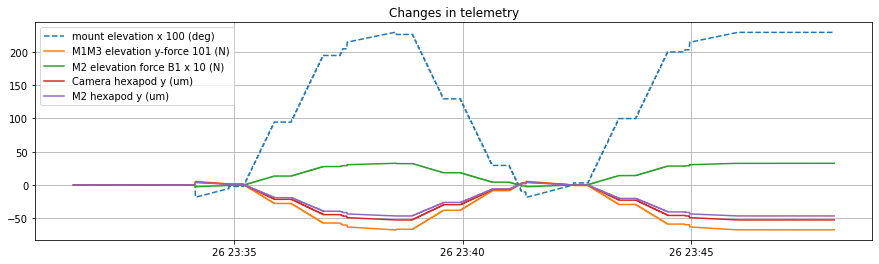

In [35]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot((dfm.actualPosition-dfm.actualPosition[0])*100, '--', label='mount elevation x 100 (deg)')
plt.plot(dfm1m3.yForces0-dfm1m3.yForces0[0], label='M1M3 elevation y-force 101 (N)')
plt.plot((dfm2.lutGravity0-dfm2.lutGravity0[0])*10, label='M2 elevation force B1 x 10 (N)')
plt.plot(dfh1.position1-dfh1.position1[0], label='Camera hexapod y (um)')
plt.plot(dfh2.position1-dfh2.position1[0], label='M2 hexapod y (um)')
plt.grid()
plt.legend()
plt.title('Changes in telemetry')

#### Check if the telescope is in tracking mode. If yes, need to stop stacking.

The alternative is to check "MT Mount status" dash board on Chronograf. Make sure there are three "False".

In [79]:
mountStatus = await mount.evt_axesInPosition.aget(timeout=5.)
rotStatus = await rot.evt_inPosition.aget(timeout=5.)
trackingStatus = mountStatus.elevation and mountStatus.azimuth and rotStatus.inPosition
print('Are we tracking?', trackingStatus)

Are we tracking? False


In [72]:
await mtcs.stop_tracking()

### put mount elevation back to 90 deg, so that we can lower M1M3

In [150]:
aa = await mount.tel_elevation.next(flush=True, timeout=5.)
current_el = aa.actualPosition

In [46]:
await moveMountConstantV(mount,current_el, 90)

This will run for 356 seconds


In [47]:
await lowerM1M3(m1m3)

m1m3 state DetailedState.LOWERING 2021-07-06 21:28:49.669873408
m1m3 state DetailedState.PARKED 2021-07-06 21:31:08.029315584


#### Close up. Put all simulators to standby

In [77]:
await salobj.set_summary_state(ptg, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [50]:
await salobj.set_summary_state(rot, salobj.State.OFFLINE)

[<State.STANDBY: 5>, <State.OFFLINE: 4>]

In [51]:
await salobj.set_summary_state(mount, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

30: Camera cable wrap telemetry is too old: dt=1.007572889328003; abs(dt) > 1


In [169]:
await salobj.set_summary_state(camhex, salobj.State.STANDBY)

[<State.STANDBY: 5>, <State.OFFLINE: 4>]

In [73]:
await salobj.set_summary_state(m2hex, salobj.State.STANDBY)

[<State.ENABLED: 2>, <State.DISABLED: 1>, <State.STANDBY: 5>]

In [75]:
await salobj.set_summary_state(m2, salobj.State.OFFLINE)

RuntimeError: Error on cmd=cmd_standby, initial_state=2: msg='Command failed', ackcmd=(ackcmd private_seqNum=1839302522, ack=<SalRetCode.CMD_FAILED: -302>, error=0, result='Complete : Failed')

In [76]:
await salobj.set_summary_state(m1m3, salobj.State.OFFLINE)

[<State.STANDBY: 5>, <State.OFFLINE: 4>]

In [179]:
await rot.cmd_clearError.set_start()

In [49]:
await m2.cmd_exitControl.set_start()

In [172]:
await checkAOSCompStates(m1m3,m2,camhex, m2hex)

starting with: M1M3 state State.OFFLINE 2021-07-01 23:39:29.483944192
          detailed state DetailedState.OFFLINE 2021-07-01 23:39:29.484043008
staring with: m2 state State.OFFLINE 2021-07-01 23:44:36.723612672
staring with: cam hex state State.OFFLINE 2021-07-01 23:46:19.115761152
          cam hex state EnabledSubstate.STATIONARY 2021-07-01 23:46:19.115953152
staring with: M2 hex state State.STANDBY 2021-07-01 23:46:48.398805248
          hex state EnabledSubstate.STATIONARY 2021-07-01 23:46:48.399011072


In [192]:
await checkSlewCompStates(ptg,mount, rot)

staring with: ptg state State.STANDBY 2021-07-02 00:00:40.821129984
staring with: mount state State.STANDBY 2021-07-02 00:00:36.661783552
staring with: rot state State.OFFLINE 2021-07-02 00:00:25.158798336
